In [1]:
## Getting the required libs and packages
! apt-get install libproj-dev proj-data proj-bin
! apt-get install libgeos-dev
! pip install --no-binary shapely shapely --force
! pip install cython
! pip install cartopy
! pip install --upgrade zarr gcsfs cftime nc-time-axis netcdf4
! pip install eofs
! pip install xarray==0.15.0
! pip install --upgrade bokeh tornado distributed

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libproj-dev is already the newest version (4.9.3-2).
proj-bin is already the newest version (4.9.3-2).
proj-data is already the newest version (4.9.3-2).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.
  Using cached https://files.pythonhosted.org/packages/44/ec/4eddbf9d17a917c51fb4ad159aa7137f506681e91ab559cf87d120e1d78d/Shapely-1.7.0.tar.gz
Skipping wheel build for shapely, due to binaries being disabled for it.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Shapely 1.7.0
    Uninstalling Shapely-1.7.0:
      Successfully uninstalled Shapely-1.7.0
    Runnin

In [0]:
## Import required packages
# !pip install -U ipykernel
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
from eofs.xarray import Eof
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import warnings
warnings.simplefilter("ignore")

In [3]:
## Initializing dask for parallel computing
from dask.distributed import Client, progress
# if __name__ == "__main__":
# client = Client(n_workers=2, threads_per_worker=2, memory_limit='1GB')
client = Client()
client

Client Scheduler: tcp://127.0.0.1:46455 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 13.65 GB


In [62]:
### Used to view the Dask dashboard in Google Colab
## Comment out if not required
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip

get_ipython().system_raw('./ngrok http 8787 &')

!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2020-06-03 02:42:44--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.54.253.53, 18.208.90.15, 18.233.191.192, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.54.253.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.6’

ngrok-stable-linux- 100%[===================>]  13.13M  12.8MB/s    in 1.0s    

2020-06-03 02:42:45 (12.8 MB/s) - ‘ngrok-stable-linux-amd64.zip.6’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
https://0560cb2a6482.ngrok.io


In [0]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

In [0]:
df_pic_pr = df.query("activity_id=='CMIP' & table_id=='day' & experiment_id == 'piControl' & variable_id=='pr'")
df_x4_pr = df.query(" table_id=='day' & experiment_id == 'abrupt-4xCO2' & variable_id=='pr'")

In [7]:
df_x4_pr['source_id'].unique()

array(['CanESM5', 'CNRM-CM6-1-HR', 'CNRM-CM6-1', 'CNRM-ESM2-1',
       'EC-Earth3-Veg', 'IPSL-CM6A-LR', 'MIROC6', 'HadGEM3-GC31-LL',
       'UKESM1-0-LL', 'MRI-ESM2-0', 'CESM2-WACCM', 'CESM2', 'GFDL-CM4',
       'GFDL-ESM4', 'SAM0-UNICON'], dtype=object)

In [8]:
df_x4_pr.groupby(['source_id'])['zstore'].count()

source_id
CESM2              1
CESM2-WACCM        1
CNRM-CM6-1         1
CNRM-CM6-1-HR      1
CNRM-ESM2-1        1
CanESM5            1
EC-Earth3-Veg      1
GFDL-CM4           2
GFDL-ESM4          1
HadGEM3-GC31-LL    1
IPSL-CM6A-LR       1
MIROC6             1
MRI-ESM2-0         1
SAM0-UNICON        1
UKESM1-0-LL        1
Name: zstore, dtype: int64

In [9]:
common_models = list(set(df_x4_pr['source_id']) & set(df_pic_pr['source_id']))
common_models

['CNRM-CM6-1',
 'GFDL-ESM4',
 'MIROC6',
 'HadGEM3-GC31-LL',
 'CESM2-WACCM',
 'CNRM-CM6-1-HR',
 'CESM2',
 'UKESM1-0-LL',
 'CanESM5',
 'IPSL-CM6A-LR',
 'MRI-ESM2-0',
 'CNRM-ESM2-1',
 'GFDL-CM4',
 'EC-Earth3-Veg']

In [0]:
import math
import numpy as np
import xarray as xr

## Class to calculate areal average

class aave(object):
    
    def __init__(self, val, lat_i=-90, lat_e=90, lon_i=-180, lon_e=180):
        self.val = val
        self.lat_i = lat_i
        self.lat_e = lat_e
        self.lon_i = lon_i
        self.lon_e = lon_e

    def get_lat_lon(self):
        lat = self.val.lat.values
        self.val.coords['lon']=(self.val.coords['lon'] + 180) % 360 - 180
        sorted_val = self.val.sortby(self.val.lon)
        lon = sorted_val.lon.values
        
        late=list(lat).index(lat[lat<=self.lat_e][len(lat[lat<=self.lat_e])-1])
        lati=list(lat).index(lat[lat>=self.lat_i][0])
        lone=list(lon).index(lon[lon<=self.lon_e][len(lon[lon<=self.lon_e])-1])
        loni=list(lon).index(lon[lon>=self.lon_i][0])
        new_val = sorted_val[lati:late+1,loni:lone+1]
        return new_val


    def get_weight(self):
        
        lat=self.get_lat_lon().lat.values
        lon=self.get_lat_lon().lon.values
        
        jlat = lat.shape[0]
        rad = 4.0*math.atan(1.0)/180.0
        re = 6371220.0
        rr = re*rad
        dlon = abs(lon[2]-lon[1])*rr
        dx = dlon*np.cos(lat*rad)
        dy = np.zeros(jlat)
        dy[0] = abs(lat[2]-lat[1])*rr
        dy[1:jlat-1] = abs(lat[2:jlat]-lat[0:jlat-2])*rr*0.5 
        dy[jlat-1] = abs(lat[jlat-1]-lat[jlat-2])*rr
        
        multi = dx*dy
        area=xr.DataArray(multi)
        area=area.rename({'dim_0':'lat'})
        return area

    @staticmethod
    def average_da(var, dim=None, weights=None):
        if weights is None:
            return var.mean(dim)
        else:
            if not isinstance(weights, xr.DataArray):
                raise ValueError("weights must be a DataArray")
    
            if var.notnull().any():
                total_weights = weights.where(var.notnull()).sum(dim=dim)
            else:
                total_weights = weights.sum(dim)
    
            return (var * weights).sum(dim) / total_weights
    
    def spatial_avg(self):
        new_val = self.get_lat_lon()
        lon_avg = new_val.mean(dim='lon')
        area = self.get_weight()
        avg = self.average_da(lon_avg, dim='lat',weights=area)
        return avg.values

In [0]:
def get_area(val,area):
    if area=='global':
        out=aave(val).spatial_avg()
    if area=='tropic':
        out=aave(val,lat_i=-30,lat_e=30).spatial_avg()
    if area=='NH':
        out=aave(val,lat_i=0).spatial_avg()
    if area=='NH-mid':
        out=aave(val,lat_i=0,lat_e=60,lon_i=-75,lon_e=0).spatial_avg()
    if area=='SPG':
        out=aave(val,lat_i=45,lat_e=60,lon_i=-50,lon_e=0).spatial_avg()
    if area=='azores':
        out=aave(val,lat_i=25,lat_e=35,lon_i=-35,lon_e=5).spatial_avg()
    if area=='icelandic':
        out=aave(val,lat_i=50,lat_e=60,lon_i=-35,lon_e=5).spatial_avg()
    return out

def get_data(df_psl, source_id):
  '''
  1) Loads data using zarr from Google cloud 
  2) combines historical with ssp245
  '''
  uri = df_psl[(df_psl.source_id == source_id)].zstore.values[0]
  gcs = gcsfs.GCSFileSystem(token='anon')
  ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
  return ds

def get_lon(val):
    '''
    Converts data to 180W to 180E longitude format
    '''
    lon=(((val.lon + 180) % 360) - 180)
    val.coords['lon']=lon
    val = val.sortby(val.lon)
    return val

def get_dpr(df_pic_pr,df_x4_pr,model):
  pr_pic = get_data(df_pic_pr, model)['pr']
  pr_x4 = get_data(df_x4_pr, model)['pr']
  pic_pr_mean = pr_pic[:18250].mean(dim='time').load()
  x4_pr_mean = pr_x4[-18250:].mean(dim='time').load()
  d_pr = ((x4_pr_mean-pic_pr_mean)*86400)
  return d_pr

def get_avg(df, model, init, end):
  ts=[]
  pr_data = get_data(df, model)['pr'][init:end]
  for i in range(len(pr_data.time)):
    ts.append(get_area(pr_data[i,:,:],'global'))
  return pd.Series(ts)

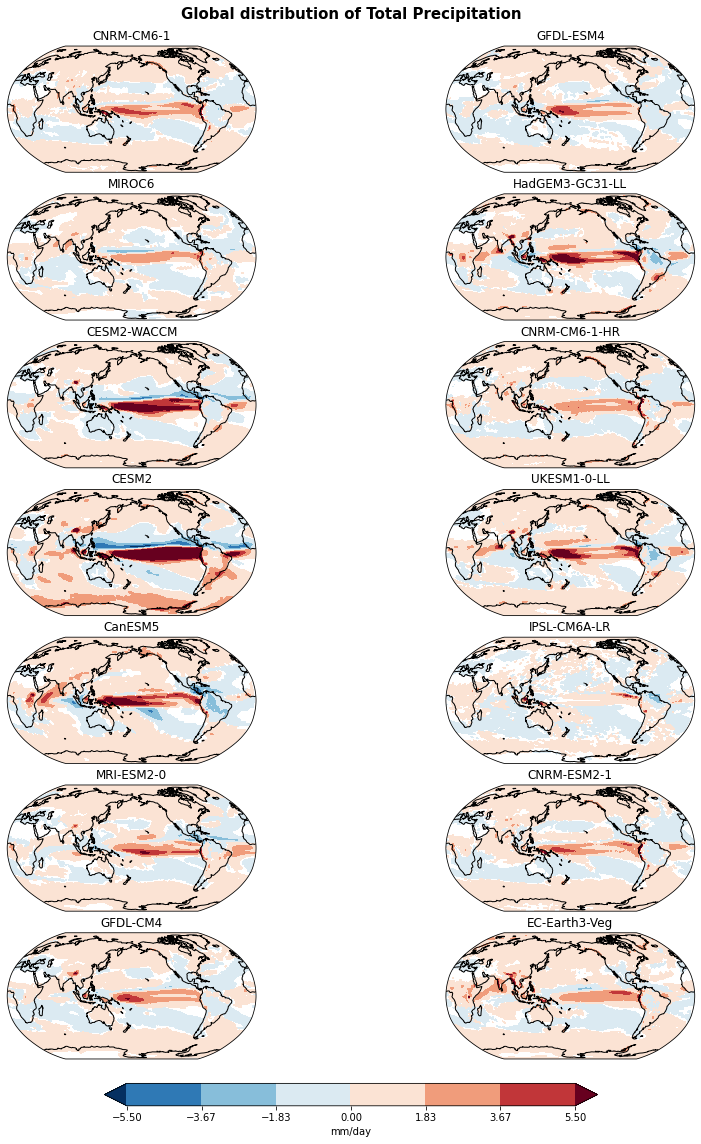

In [12]:
## Plotting total precip change
proj = ccrs.Robinson(central_longitude = 180)
fig, axs = plt.subplots(7,2,figsize=[14,18],subplot_kw=dict(projection=proj))
fig.suptitle('Global distribution of Total Precipitation',fontsize=15,weight='bold')
clevs = np.linspace(-5.5,5.5,11)
m = 0
n = 0
for i in range(0,14):
  dpr = get_dpr(df_pic_pr,df_x4_pr,common_models[i])
  d_pr = dpr.where((dpr<-0.1) | (dpr>.1))
  a = d_pr.plot.contourf(ax=axs[n,m], level=clevs, robust=True, transform=ccrs.PlateCarree(), cmap='RdBu_r',extend='both',add_colorbar=False,vmin=-5.5,vmax=5.5)
  # plt.contourf(d_pr.lon,d_pr.lat,d_pr,robust=True, transform=ccrs.PlateCarree(), cmap='bwr',extend='both')
  axs[n,m].coastlines()
  axs[n,m].set_global()
  axs[n,m].set_title(common_models[i])
  m=m+1
  if m>1:
    m=0
    n=n+1
  else:
    continue
plt.tight_layout()
fig.subplots_adjust(top=0.95)
fig.colorbar(a,ax=axs.ravel().tolist(),orientation='horizontal',pad=0.02, shrink=0.5,label='mm/day')

In [0]:
# fig.savefig("pr_spatial.eps", format='eps', dpi=350, bbox_inches='tight',pad_inches=0.1)
# from google.colab import files
# files.download("pr_spatial.eps")
ds1 = get_data(df_pic_pr, common_models[6])['pr'][:18250]
ds2 = get_data(df_x4_pr, common_models[6])['pr'][-18250:]

In [0]:
test = ds1.sel(lat=slice(-20,20))
test2 = ds2.sel(lat=slice(-20,20))

In [109]:
test.load()
%time test2.load()

CPU times: user 4.59 s, sys: 1.6 s, total: 6.19 s
Wall time: 40.2 s


<xarray.DataArray 'pr' (time: 18250, lat: 42, lon: 288)>
array([[[2.70077627e-09, 3.54486485e-09, 1.81756804e-10, ...,
         1.47113701e-06, 7.51000243e-07, 1.20111537e-07],
        [6.73637075e-08, 1.82842506e-08, 1.04190310e-08, ...,
         1.21733399e-06, 5.35325114e-07, 9.27361086e-08],
        [1.19166180e-06, 4.81593361e-07, 3.55617722e-08, ...,
         2.31374656e-07, 1.19957477e-07, 9.53118970e-08],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[7.94557948e-08, 1.97002148e-08, 1.04815294e-08, ...,
         1.27118494e-06, 4.40598541e-07, 2.63260318e-07],
        [1.16863879e-08, 1.41950292e-08, 2.25378738e-08, ...,
         6.52168865e-07, 2.01713206e-08, 1.01463735e-08],
        [1.50877870e-08, 9.31596311e-09, 3.26066818e-08, ...,
         6.44603801e-07, 1.05873310e-08, 9.07829811e-09],
        ...,
        [1.37037513e-14, 2.39993724e-14, 2.21393592e-14, ...,
         1.14148476e-16, 1.25749601e-17, 2.51070921e-15],
        [1.05878007e-13, 1.01304361e-13, 8.33924062e-14, ...,
         7.89312599e-14, 7.86283405e-14, 9.63755239e-14],
        [2.82837610e-13, 1.88733686e-13, 2.35958551e-13, ...,
         5.46952990e-08, 3.20517550e-08, 2.62288236e-09]],

       [[2.42062515e-06, 2.00444697e-06, 1.62833715e-07, ...,
         3.63482604e-06, 3.24337134e-06, 2.35684661e-06],
        [1.39254303e-06, 1.11584200e-06, 1.09204223e-07, ...,
         1.04183698e-06, 9.58535338e-07, 1.86494378e-06],
        [4.57831078e-07, 1.00586689e-07, 3.11234857e-07, ...,
         7.14518933e-07, 8.56012718e-07, 9.66919288e-07],
        ...,
        [1.44498657e-09, 2.23443920e-14, 1.52144024e-14, ...,
         6.17960298e-17, 5.29562749e-17, 4.48839188e-10],
        [2.36875906e-08, 1.86241866e-08, 5.19778936e-13, ...,
         3.33229301e-14, 4.96234896e-14, 8.61603774e-11],
        [1.10840503e-07, 1.71611447e-07, 1.07194900e-07, ...,
         2.76322911e-08, 4.32558807e-08, 5.40481153e-08]],

       ...,

       [[1.82864692e-08, 7.85185028e-10, 4.22006652e-09, ...,
         1.43362257e-07, 1.49149727e-07, 7.08088699e-09],
        [3.26957461e-09, 1.98756194e-08, 1.09082317e-08, ...,
         1.73994508e-07, 1.26475868e-06, 3.76061529e-08],
        [2.43473619e-09, 7.41809458e-09, 5.31872368e-09, ...,
         2.27532304e-08, 5.87283502e-08, 9.63481472e-09],
        ...,
        [6.57729379e-06, 8.60894761e-06, 1.22693145e-05, ...,
         6.14502869e-06, 6.52958443e-06, 6.70880991e-06],
        [2.71410318e-06, 2.57853071e-06, 3.39425924e-06, ...,
         1.70653948e-06, 2.16621220e-06, 2.64633832e-06],
        [7.84817587e-07, 1.44623414e-06, 1.97293821e-06, ...,
         3.33455148e-07, 3.48443791e-07, 4.32640178e-07]],

       [[1.27243993e-07, 1.48836889e-07, 1.09144601e-07, ...,
         6.56271482e-08, 5.01526820e-08, 8.15389001e-08],
        [9.14541047e-08, 6.60462618e-08, 3.89722246e-08, ...,
         3.97196303e-08, 8.21196338e-08, 7.30813170e-08],
        [3.79318053e-08, 3.08252979e-08, 1.36467371e-08, ...,
         4.74343089e-08, 4.71294648e-08, 5.02973343e-08],
        ...,
        [1.99273254e-05, 3.81315112e-05, 4.77378198e-05, ...,
         1.14156501e-06, 3.08110339e-06, 9.76333286e-06],
        [9.19090598e-06, 1.63960958e-05, 3.22020969e-05, ...,
         5.21546042e-08, 6.56133579e-07, 3.01313594e-06],
        [1.95441544e-06, 7.76843990e-06, 1.49540128e-05, ...,
         4.94059993e-09, 1.13773417e-08, 1.62203747e-07]],

       [[7.17602262e-08, 5.19296002e-08, 3.35698047e-08, ...,
         1.70415944e-07, 3.31329488e-07, 9.61761515e-08],
        [6.21425897e-08, 5.20868433e-08, 4.84939591e-08, ...,
         7.85553311e-07, 5.57658382e-07, 8.08282508e-08],
        [6.5607

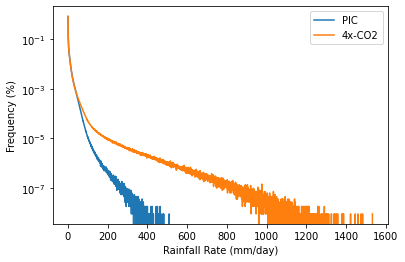

In [145]:
fig = plt.figure()
binwidth=0.5
ax = fig.add_subplot(1, 1, 1)
hist2, bins = np.histogram((test2*86400), bins=np.arange((test2*86400).min(), (test2*86400).max() + binwidth, binwidth), normed=True)
hist, bins = np.histogram((test*86400), bins=np.arange((test2*86400).min(), (test2*86400).max() + binwidth, binwidth), normed=True)
bin_centers = (bins[1:]+bins[:-1])*0.5
plt.plot(bin_centers, hist,label='PIC')
plt.plot(bin_centers, hist2, label='4x-CO2')
ax.set_yscale('log')
ax.set_ylabel('Frequency (%)')
ax.set_xlabel('Rainfall Rate (mm/day)')
plt.legend()

In [0]:
t50 = test.resample(time="1AS").mean(dim='time')
t502 = test2.resample(time="1AS").mean(dim='time')

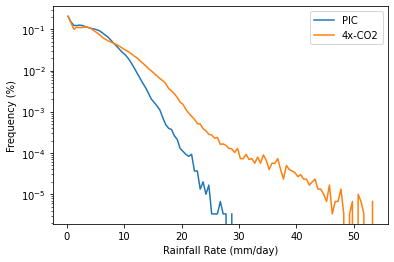

In [144]:
fig = plt.figure()
binwidth=0.5
ax = fig.add_subplot(1, 1, 1)
hist, bins = np.histogram((t50*86400), bins=np.arange((t50*86400).min(), (t50*86400).max() + binwidth, binwidth), normed=True)
hist2, bins2 = np.histogram((t502*86400), bins=np.arange((t502*86400).min(), (t502*86400).max() + binwidth, binwidth), normed=True)
bin_centers = (bins[1:]+bins[:-1])*0.5
bin_centers2 = (bins2[1:]+bins2[:-1])*0.5
plt.plot(bin_centers, hist,label='PIC')
plt.plot(bin_centers2, hist2, label='4x-CO2')
ax.set_yscale('log')
ax.set_ylabel('Frequency (%)')
ax.set_xlabel('Rainfall Rate (mm/day)')
plt.legend()